In [1]:
def tree_paths(tree):
    
    children_left = tree.children_left
    children_right = tree.children_right
    values = tree.value
    
    paths = []
    prob = []
    path = []
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()    
               
        while len(path)>parent_depth+1:
            path.pop()
        path.append(node_id)
        
        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            paths.append(path.copy())
            true = values[node_id][0][0].copy()
            false = values[node_id][0][1].copy()
            prob.append(true/(true+false))

    return paths, prob

In [2]:
def forest_paths(model):    
    forest_attributes = []
    baseline_means = []
    
    for treeEst in model.estimators_:
        path_thresholds = []
        path_features = []
        prob_full = []
        
        children_left = treeEst.tree_.children_left
        children_right = treeEst.tree_.children_right
        all_thresholds = treeEst.tree_.threshold
        all_features = treeEst.tree_.feature

        paths, prob = tree_paths(treeEst.tree_)
        baseline_means.append(np.mean(prob))

        for i in range(len(paths)):
            thresholds = []
            features = []
            for j in range(len(paths[i])-1):
                if paths[i][j+1] == children_right[paths[i][j]]:
                    thresholds.append(all_thresholds[paths[i][j]])
                else:
                    thresholds.append(-all_thresholds[paths[i][j]])
                features.append(all_features[paths[i][j]])
            path_thresholds.append(thresholds.copy())
            path_features.append(features.copy())
    
        tree_atributes = pd.DataFrame([path_features, path_thresholds, np.hstack(prob)]).T
        tree_atributes.columns = ['features','thresholds','prob']
        forest_attributes.append(tree_atributes.copy())
    return forest_attributes, np.mean(baseline_means)

In [3]:
def conditional_prob(feature_lists,model):
    forest_attributes, baseline_mean = forest_paths(model)
    
    probabilities_full = []
    for f_list in feature_lists: #an ordered list of features and directions
        #extract directions and feature identities
        f_ids = abs(np.asarray(f_list))
        f_dirs = f_list/f_ids
        tree_probabilities = []
        for tree_frame in forest_attributes:
            features_in_tree = np.unique(np.hstack(tree_frame['features']))
            if np.all(np.isin(f_ids,features_in_tree)):
                relevant_leaves = []
                #look in all paths for ones that meet the conditions
                for index, path in tree_frame.iterrows(): 
                    if np.all(np.isin(f_ids,path['features'])): #all features are in the list
                        feature_loc = []
                        for feature in f_ids: #get the locations of features in question
                            feature_loc.append(path['features'].index(feature))
                        #features are in the right order and have the right directions
                        correct_order = np.all(feature_loc[:-1] <= feature_loc[1:])
                        selected_threshs = np.asarray(path['thresholds'])[feature_loc]
                        correct_dir = np.all(
                            np.equal(selected_threshs/abs(selected_threshs),f_dirs)
                        )
                        if correct_order and correct_dir:
                            relevant_leaves.append(path['prob'].copy())
                tree_probabilities.append(np.nanmean(relevant_leaves))
        probabilities_full.append(np.nanmean(tree_probabilities))
    return np.asarray(probabilities_full), baseline_mean 

In [6]:
%run ../utils_rf
from sklearn import tree

In [8]:
#read training data
file = "../../../tables/model_input/noc_answers.csv"
x, x_agg, y, y_agg, x_noclvl, y_noclvl = data_proccess(file,True)
x.drop(['work_num_1','work_num_2','work_num_3','work_num_4','work_num_5','work_num_6'],axis=1,inplace=True)

#grab just the noc codes to cut out test nocs from main noc table
train_nocs = pd.read_csv(file,usecols=['noc_code']).drop_duplicates()

In [14]:
# reading projections and tieing to O*NET set to do complete correlation check
file ="../../../tables/model_input/noc_scores.csv"
nocs = pd.read_csv(file,index_col=['noc'])
nocs.sort_index(inplace=True)
nocs.drop(['Unnamed: 0'],axis=1,inplace=True)
nocs = np.round(nocs).astype(int)
nocs.drop(train_nocs['noc_code'],inplace=True)

full_x = pd.concat([nocs,x_noclvl.droplevel(0)],axis=0,join='inner')

full_projections = pd.read_csv('../../../tables/model_output/RF full set.csv',index_col=['noc'])

full = full_x.merge(full_projections,left_index=True,right_index=True)

In [47]:
law_good = full.loc[np.logical_and(full['value.Law and Government']>3,
               np.logical_or(
                   np.logical_or(full['value.Static Strength']>3,
                            full['value.Category Flexibility']>3),
                            full['value.Written Expression']>3))]

law_good[['inc.projection','dec.projection']].sort_values('inc.projection',ascending=False)

,inc.projection,dec.projection
2263,0.682359,0.216607
432,0.631492,0.202189
1314,0.631060,0.187272
714,0.534084,0.409036
1224,0.534084,0.409036
3011,0.529241,0.166308
2151,0.522556,0.401879
125,0.522449,0.251381
2152,0.505225,0.151839
431,0.494008,0.192022


In [50]:
comp_elec_good = full.loc[np.logical_and(full['value.Computers and Electronics']>3,
               np.logical_or(
                   np.logical_or(full['value.Problem Sensitivity']>3,
                            full['value.Critical Thinking']>3),
                            full['value.Systems Evaluation']>3))]

comp_elec_good.loc[comp_elec_good['trainset']==0][['inc.projection','dec.projection']].sort_values('inc.projection',ascending=False)

,inc.projection,dec.projection
2145,0.734025,0.183565
211,0.711524,0.200197
1113,0.696058,0.132449
2147,0.687551,0.111256
2134,0.667260,0.130639
4167,0.661948,0.149014
1423,0.654491,0.115770
2175,0.653445,0.132449
2242,0.647095,0.136947
2255,0.642946,0.132449


In [53]:
chem_good = full.loc[np.logical_and(full['value.Chemistry']>3,
               np.logical_or(
                   np.logical_or(full['value.Social Perceptiveness']>3,
                            full['value.Speech Clarity']>3),
                            full['value.Therapy and Counseling']>3))]

chem_good.loc[chem_good['trainset']==0][['inc.projection','dec.projection']].sort_values('inc.projection',ascending=False)

,inc.projection,dec.projection
3131,0.836523,0.202147
2263,0.682359,0.216607
2113,0.388467,0.164887
3112,0.369830,0.244334


In [62]:
comp_elec_bad = full.loc[np.logical_and(full['value.Computers and Electronics']>3,
                   np.logical_and(full['value.Systems Evaluation']<3,
                            full['value.Originality']<3))]

comp_elec_bad.loc[comp_elec_bad['trainset']==0][['inc.projection','dec.projection']].sort_values('inc.projection')

,inc.projection,dec.projection
1251,0.219305,0.570567
1221,0.251700,0.478119
1241,0.251700,0.478119


In [71]:
law_bad = full.loc[np.logical_and(full['value.Law and Government']>3,
               np.logical_and(np.logical_and(full['value.Category Flexibility']<4,
                            full['value.Written Expression']<4),
                                 full['value.Static Strength']<4))]

law_bad.loc[law_bad['trainset']==0][['inc.projection','dec.projection']].sort_values('inc.projection')

,inc.projection,dec.projection
1422,0.288367,0.471972
4423,0.337247,0.270352
4421,0.341304,0.440032
2254,0.555256,0.149014


In [63]:
chem_bad = full.loc[np.logical_and(full['value.Chemistry']>3,
               np.logical_or(full['value.Memorization']<3,
                            full['value.Number Facility']<3))]

chem_bad.loc[chem_bad['trainset']==0][['inc.projection','dec.projection']].sort_values('inc.projection')

,inc.projection,dec.projection
9243,0.123354,0.486588
6621,0.168300,0.451841
3112,0.369830,0.244334
2123,0.381169,0.206675
2113,0.388467,0.164887
2142,0.469662,0.144256


In [76]:
rf = RandomForestClassifier(**init_params('cat'))
rf.fit(x,y['increase'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Trying if simple way does the same thing

In [14]:
bad_predictions = pd.Series(rf.predict_proba(nocs)[:,0],index=nocs.index)
SAK_check = pd.melt(nocs.reset_index(),id_vars='noc')
SAK_check['high_score'] = SAK_check['value']>3
SAK_check_bad = SAK_check.merge(pd.DataFrame(bad_predictions),left_on='noc',right_index=True)
SAK_check_bad = SAK_check_bad.groupby(['variable','high_score']).mean()[0].sort_values(ascending=False)

SAK_check_good = SAK_check.merge(
    pd.DataFrame(full_projections['inc.projection']),left_on='noc',right_index=True)
SAK_check_good = SAK_check_good.groupby(['variable','high_score']).agg(
    {'inc.projection':['mean','std']})

In [45]:
full[['value.Memorization','value.Fluency of Ideas','value.Systems Evaluation','value.Instructing',
     'value.Persuasion','value.Service Orientation','value.Fine Arts','value.Originality']].mean()

value.Memorization           2.301031
value.Fluency of Ideas       2.812371
value.Systems Evaluation     2.538144
value.Instructing            2.729897
value.Persuasion             2.758763
value.Service Orientation    2.898969
value.Fine Arts              1.230928
value.Originality            2.750515
dtype: float64

In [64]:
full.loc[full['value.Originality']>3]['inc.projection'].agg({'inc.projection':['mean','min','max']})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


inc.projection  mean    0.456913
                min     0.173913
                max     0.894737
Name: inc.projection, dtype: float64

In [74]:
full.loc[full['inc.projection']>0.5].agg({'value.Originality':['mean','min','max']})

,value.Originality
mean,3.126316
min,2.000000
max,4.000000


In [23]:
SAK_check_good.sort_values(('inc.projection','mean'),ascending=False)

inc.projection          
                                                      mean       std
variable                         high_score                         
value.Science                    True             0.578793  0.174363
value.Flexibility of Closure     True             0.578111  0.175272
value.Mathematics Skill          True             0.564334  0.119038
value.Category Flexibility       True             0.543901  0.136650
value.History and Archeology     True             0.541748  0.019031
value.Physics                    True             0.534475  0.147318
value.Operations Analysis        True             0.526689  0.081286
value.Computers and Electronics  True             0.519259  0.129718
value.Medicine and Dentistry     True             0.507883  0.192013
value.Mathematical Reasoning     True             0.506882  0.148031
value.Biology                    True             0.500672  0.206477
value.Engineering and Technology True             0.494769  0.149705
value.Systems Analysis           True             0.493690  0.168987
value.Geography                  True             0.489221  0.107933
value.Installation               True             0.484347  0.037848
value.Time Sharing               True             0.475974  0.219936
value.Systems Evaluation         True             0.475807  0.178084
value.Active Learning            True             0.468805  0.163535
value.Complex Problem Solving    True             0.468580  0.150092
value.Telecommunications         True             0.468354  0.132248
value.Number Facility            True             0.463852  0.141640
value.Fine Arts                  True             0.461781  0.170865
value.Design                     True             0.458276  0.162404
value.Originality                True             0.457212  0.151738
value.Writing                    True             0.457071  0.139762
value.Chemistry                  True             0.455509  0.217076
value.Economics and Accounting   True             0.454764  0.127216
value.Information Ordering       True             0.454127  0.156295
value.Fluency of Ideas           True             0.449544  0.135414
value.Equipment Selection        True             0.448930       NaN
...                                                    ...       ...
value.Far Vision                 True             0.295134  0.174356
value.Inductive Reasoning        False            0.293083  0.154540
value.Mechanical                 True             0.293009  0.158944
value.Gross Body Equilibrium     True             0.288408  0.162465
value.Manual Dexterity           True             0.282596  0.180343
value.Problem Sensitivity        False            0.281042  0.160789
value.Speaking                   False            0.279182  0.161927
value.Arm-Hand Steadiness        True             0.278796  0.168630
value.Deductive Reasoning        False            0.275878  0.147084
value.Reading Comprehension      False            0.275739  0.154134
value.Food Production            True             0.275670  0.216465
value.Critical Thinking          False            0.275149  0.150937
value.Written Comprehension      False            0.273858  0.153406
value.English Language           False            0.270813  0.159870
value.Operation Monitoring       True             0.265031  0.166642
value.Speed of Limb Movement     True             0.258148  0.205258
value.Auditory Attention         True             0.254027  0.096863
value.Control Precision          True             0.252728  0.164961
value.Active Listening           False            0.252488  0.149460
value.Multilimb Coordination     True             0.251914  0.171779
value.Oral Expression            False            0.247648  0.147149
value.Trunk Strength             True             0.242900  0.143468
value.Spatial Orientation        True             0.225138  0.052994
value.Oral Comprehension         False            0.223187  0.135162
value.Operation and Control      True     

In [97]:
SAK_check_trainset = pd.melt(x_noclvl.reset_index(),id_vars='noc_code',value_vars = x_noclvl.columns)
SAK_check_trainset['high_score'] = SAK_check_trainset['value']>3
SAK_check_trainset = SAK_check_trainset.merge(y_noclvl,left_on='noc_code',right_on='noc_code')
SAK_check_trainset = SAK_check_trainset.groupby(['variable','high_score']).mean()['increase']
SAK_check_trainset = SAK_check_trainset.sort_values(ascending=False)

Feature Importances

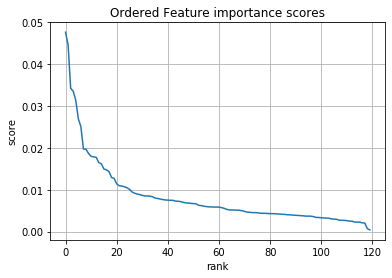

In [30]:
rf_features = pd.Series(rf.feature_importances_,index=x.columns)
plt.plot(range(120),rf_features.sort_values(ascending=False))
plt.title('Ordered Feature importance scores')
plt.ylabel('score')
plt.xlabel('rank')
plt.grid()
plt.savefig('feature importance.png')
plt.show()

In [84]:
selected_features_scores = rf_features.sort_values(ascending=False).iloc[0:20]
selected_features_ix = np.where(np.isin(x.columns,selected_features_scores.index))[0]
selected_features = x.columns[selected_features_ix]

Simple correlation first

In [24]:
knowledges = np.unique(pd.read_excel('../../raw_data/knowledge.xlsx')['Element Name'])
abillities = np.unique(pd.read_excel('../../raw_data/Abilities.xlsx')['Element Name'])
skills = np.unique(pd.read_excel('../../raw_data/skills.xlsx')['Element Name'])

In [25]:
SAKs = pd.concat([
    pd.DataFrame({'SAK':knowledges,'type':'K'}),
    pd.DataFrame({'SAK':abillities,'type':'A'}),
    pd.DataFrame({'SAK':skills,'type':'S'})
])
SAKs['SAK'] = 'value.' + SAKs['SAK'].astype(str)

In [90]:
selected_SAKs = SAKs.merge(pd.DataFrame(selected_features_scores),left_on='SAK',right_index=True)

In [91]:
selected_SAKs.sort_values(0,ascending=False)

,SAK,type,0
20,value.Persuasion,S,0.047657
13,value.Fluency of Ideas,A,0.044628
30,value.Systems Evaluation,S,0.034287
6,value.Computers and Electronics,K,0.033543
22,value.Memorization,A,0.031377
29,value.Originality,A,0.026983
26,value.Service Orientation,S,0.025081
31,value.Technology Design,S,0.019743
32,value.Transportation,K,0.019691
8,value.Instructing,S,0.018671


In [44]:

sffs_prob_features = ['value.Learning Strategies',
             'value.Monitoring',
             'value.Persuasion',
             'value.Service Orientation',
             'value.Management of Material Resources',
             'value.Information Ordering',
             'value.Memorization',
             'value.Flexibility of Closure',
             'value.Time Sharing',
             'value.Finger Dexterity',
             'value.Far Vision',
             'value.Computers and Electronics',
             'value.Chemistry',
             'value.Biology']

x_sffs = x.loc[:,sffs_prob_features]

In [95]:
rf_sffs = RandomForestClassifier(**init_params('cat'))
rf_sffs.fit(x_sffs,y['increase'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [99]:
sffs_feature_scores = pd.Series(rf_sffs.feature_importances_,index=x_sffs.columns)
sffs_SAKs = SAKs.merge(pd.DataFrame(sffs_feature_scores),left_on='SAK',right_index=True)

In [100]:
sffs_SAKs.sort_values(0,ascending=False)

,SAK,type,0
6,value.Computers and Electronics,K,0.139233
26,value.Service Orientation,S,0.131518
22,value.Memorization,A,0.121910
20,value.Persuasion,S,0.115079
3,value.Chemistry,K,0.090728
11,value.Finger Dexterity,A,0.073415
1,value.Biology,K,0.060736
45,value.Time Sharing,A,0.051729
10,value.Learning Strategies,S,0.044400
15,value.Monitoring,S,0.042436


In [78]:
cor_matrix = pd.DataFrame(np.corrcoef(full.T),columns=full.columns,index=full.columns)
inc_corrs = cor_matrix['inc.projection']
dec_corrs = cor_matrix['dec.projection']

inc_corrs = pd.DataFrame({
    'correlation with inc':inc_corrs,
    'non SFFS model top 20':np.isin(inc_corrs.index,selected_features),
    'chosen by SFFS':np.isin(inc_corrs.index,sffs_prob_features)})

inc_corrs = inc_corrs.merge(SAKs,left_index=True,right_on='SAK')

In [80]:
inc_corrs.sort_values('correlation with inc',ascending=False)[0:20]

,correlation with inc,non SFFS model top 20,chosen by SFFS,SAK,type
20,0.551937,True,True,value.Persuasion,S
26,0.535302,True,True,value.Service Orientation,S
29,0.534655,True,False,value.Originality,A
22,0.517167,True,True,value.Memorization,A
13,0.501668,True,False,value.Fluency of Ideas,A
29,0.478662,True,False,value.Systems Analysis,S
23,0.478250,False,False,value.Reading Comprehension,S
4,0.473966,False,False,value.Deductive Reasoning,A
1,0.467863,False,False,value.Active Listening,S
27,0.461488,False,False,value.Oral Comprehension,A


Now for approach 1

First get all the thresholds

In [45]:
forest_attributes, baseline_mean = forest_paths(rf)

features = []
thresholds = []

for tree in forest_attributes:
    features.append(np.hstack(tree['features']).copy())
    thresholds.append(np.hstack(tree['thresholds']).copy())
features = np.hstack(features)
thresholds = np.hstack(thresholds)

pairs = pd.DataFrame({'feature':features,'threshold':abs(thresholds)})
max_thresh = pairs.groupby('feature').max()-0.5
min_thresh = pairs.groupby('feature').min()+0.5

max_thresh = max_thresh.loc[selected_features_ix]
max_thresh.index = pd.MultiIndex.from_product([selected_features,['greater than']])
min_thresh = min_thresh.loc[selected_features_ix]
min_thresh.index = pd.MultiIndex.from_product([selected_features,['less than']])

relevant_thresh = max_thresh.append(min_thresh)

In [46]:
combos_to_try =  [[14, 12],[59, 12],[66, 12],[84, 12],[87, 12],[116, 12],[91, 47],[6, 48],[20, 48],
 [21, 48],[42, 48],[85, 48],[86, 48],[96, 48],[2, 53],[14, 53],[21, 53],[39, 53],[40, 53],[83, 53],
 [108, 53],[116, 53],[56, 63],[95, 63],[14, 66],[41, 66],[82, 91],[87, 91],[88, 97],[99, 119],[107, 119]]

In [47]:
main_features = []
for feature in selected_features_ix:
    main_features.append([feature])
    main_features.append([-1*feature])
    
cond_combos = []
for feature in selected_features_ix:
    for i in range(0,120):
        cond_combos.append([i,feature])
        cond_combos.append([-1*i,feature])
        cond_combos.append([i,-1*feature])
        cond_combos.append([-1*i,-1*feature])
        
selected_cond_combos = []
for combo in combos_to_try:
    selected_cond_combos.append([combo[0],combo[1]])
    selected_cond_combos.append([-1*combo[0],combo[1]])
    selected_cond_combos.append([combo[0],-1*combo[1]])
    selected_cond_combos.append([-1*combo[0],-1*combo[1]])

Single Feature

In [48]:
main_probs, baseline = conditional_prob(main_features,rf)

In [49]:
main_prob_diffs = pd.DataFrame({'prob': main_probs,
                                "pct diff from baseline": ((main_probs-baseline)/baseline)*100},
                            index=pd.MultiIndex.from_product(
                                [selected_features,['greater than','less than']]))

In [50]:
main_prob_diffs = main_prob_diffs.merge(relevant_thresh,left_index=True,right_index=True)

In [100]:
SAK_check.loc['value.Reaction Time']

high_score
False    0.405622
True     0.252560
Name: 0, dtype: float64

In [52]:
main_prob_diffs.sort_values('pct diff from baseline').sort_values('prob',ascending=False)

,,prob,pct diff from baseline,threshold
value.Memorization,greater than,0.532315,54.956953,2.0
value.Chemistry,greater than,0.474166,38.029897,2.0
value.Technology Design,greater than,0.463209,34.840340,2.0
value.Visualization,greater than,0.455285,32.533697,3.0
value.Negotiation,less than,0.446828,30.071710,3.0
value.Transportation,less than,0.442956,28.944492,2.0
value.Systems Evaluation,greater than,0.439130,27.830987,3.0
value.Originality,greater than,0.422440,22.972505,3.0
value.Fluency of Ideas,greater than,0.416445,21.227376,3.0
value.Service Orientation,greater than,0.393379,14.512836,3.0


In [ ]:
main_prob_diffs.to_csv(r'../../tables/prob_diffs.csv'
                 ,index=True,header=True)

Feature combos selected from analysis 2

In [45]:
cond_probs, baseline = conditional_prob(selected_cond_combos,rf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [60]:
feature_combos = []
for combo in combos_to_try:
    feature_combos.append((x.columns[combo[0]],x.columns[combo[1]]))

In [61]:
cond_prob_diffs = pd.DataFrame({'prob': cond_probs,
                                "pct diff from baseline": ((cond_probs-baseline)/baseline)*100},
                                index=pd.MultiIndex.from_product([feature_combos,
                                            ['greater then greater',
                                            'less then greater',
                                            'greater then less',
                                            'less then less']]))


In [62]:
cond_prob_diffs.loc[abs(cond_prob_diffs['pct diff from baseline'])>=50]

prob  \
(value.Instructing, value.Persuasion)              greater then less     0.102355   
(value.Static Strength, value.Persuasion)          less then less        0.147245   
(value.Sound Localization, value.Persuasion)       less then less        0.726801   
(value.Law and Government, value.Persuasion)       greater then greater  0.124402   
                                                   less then less        0.553760   
(value.Critical Thinking, value.Memorization)      greater then greater  0.637415   
(value.Installation, value.Memorization)           less then greater     0.613000   
(value.Deductive Reasoning, value.Memorization)    greater then greater  0.582603   
(value.Speech Recognition, value.Memorization)     greater then greater  0.605470   
(value.Speech Clarity, value.Memorization)         greater then greater  0.564597   
(value.Engineering and Technology, value.Memori... greater then greater  0.598390   
(value.Writing, value.Visualization)               greater then less     0.157559   
(value.Instructing, value.Visualization)           less then less        0.088498   
(value.Programming, value.Visualization)           less then greater     0.571713   
(value.Fluency of Ideas, value.Visualization)      less then greater     0.122674   
                                                   less then less        0.093740   
(value.Originality, value.Visualization)           greater then greater  0.531108   
                                                   less then greater     0.140247   
(value.Auditory Attention, value.Visualization)    less then greater     0.541487   
(value.Law and Government, value.Visualization)    less then greater     0.615816   
(value.Arm-Hand Steadiness, value.Reaction Time)   greater then less     0.669074   
(value.Computers and Electronics, value.Reactio... greater then greater  0.168383   
(value.Instructing, value.Static Strength)         less then less        0.128757   
(value.Problem Sensitivity, value.Static Strength) less then greater     0.058836   
                                                   less then less        0.074901   
(value.Hearing Sensitivity, value.Customer and ... greater then greater  0.000000   
                                                   greater then less     0.049645   
(value.Administration and Management, value.Cus... less then greater     0.000000   
                                                   greater then less     0.160505   
                                                   less then less        0.046154   
(value.Clerical, value.Design)                     less then greater     0.123319   
                                                   less then less        0.074500   
(value.Mechanical, value.Transportation)           less then greater     0.160434   
                                                   less then less        0.165652   
(value.Medicine and Dentistry, value.Transporta... greater then greater  0.600000   
                                                   less then greater     0.113479   

                                                                         pct diff from baseline  
(value.Instructing, value.Persuasion)              greater then less                 -70.204330  
(value.Static Strength, value.Persuasion)          less then less                    -57.136864  
(value.Sound Localization, value.Persuasion)       less then less                    111.572116  
(value.Law and Government, value.Persuasion)       greater then greater              -63.786566  
                                                   less then less                     61.199571  
(value.Critical Thinking, value.Memorization)      greater then greater               85.551835  
(value.Installation, value.Memorization)           less then greater                  78.444416  
(value.Deductive Reasoning, value.Memorization)    greater then greater               69.595997  
(value.Speech Recognition, value.Memorization)   

Checking all features for flips

In [16]:
cond_probs, baseline = conditional_prob(cond_combos,rf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [55]:
feature0= []
feature1= []
for combo in cond_combos:
    feature0.append(x.columns[abs(combo[0])])
    feature1.append(x.columns[abs(combo[1])])

In [82]:
directions = np.tile(
    ['greater then greater','less then greater','greater then less','less then less'],2400)

In [104]:
cond_prob_diffs = pd.DataFrame({'feature0':feature0,'feature1':feature1,'direction':directions,
                                 'prob': cond_probs,
                                "pct diff from baseline": ((cond_probs-baseline)/baseline)*100})
cond_prob_diffs = cond_prob_diffs.dropna()

In [171]:
compare = cond_prob_diffs.merge(main_prob_diffs.reset_index(),
                      how='left',left_on='feature1',right_on='level_0')

In [172]:
effect = []
for index, row in compare.iterrows():
    if row['level_1'] == 'greater than' and row['pct diff from baseline_y']>0:
        effect.append('pos')
    if row['level_1'] == 'less than' and row['pct diff from baseline_y']<0:
        effect.append('pos')
    if row['level_1'] == 'greater than' and row['pct diff from baseline_y']<0:
        effect.append('neg')
    if row['level_1'] == 'less than' and row['pct diff from baseline_y']>0:
        effect.append('neg')
compare['effect'] = effect

In [173]:
cond_effect = []
for index, row in compare.iterrows():
    row_dir = row['direction'][row['direction'].rindex(' ')+1:]
    if row_dir == 'greater' and row['pct diff from baseline_x']>0:
        cond_effect.append('pos')
    if row_dir == 'less' and row['pct diff from baseline_x']<0:
        cond_effect.append('pos')
    if row_dir == 'greater' and row['pct diff from baseline_x']<0:
        cond_effect.append('neg')
    if row_dir == 'less' and row['pct diff from baseline_x']>0:
        cond_effect.append('neg')
compare['cond_effect'] = cond_effect

In [273]:
flips = compare.loc[
    np.logical_or(np.logical_and(compare['effect']=='neg',compare['cond_effect']=='pos'),
                  np.logical_and(compare['effect']=='pos',compare['cond_effect']=='neg'))]

In [285]:
flips.loc[flips['level_0'] == 'value.Negotiation'].sort_values('prob_x',ascending=False)

,feature0,feature1,direction,prob_x,pct diff from baseline_x,level_0,level_1,prob_y,pct diff from baseline_y,effect,cond_effect
521,value.Active Listening,value.Negotiation,greater then greater,0.941176,173.976752,value.Negotiation,less than,0.446828,30.071710,neg,pos
1090,value.Biology,value.Negotiation,less then less,0.941176,173.976752,value.Negotiation,greater than,0.378644,10.223464,pos,neg
1085,value.Biology,value.Negotiation,greater then greater,0.941176,173.976752,value.Negotiation,less than,0.446828,30.071710,neg,pos
965,value.Sound Localization,value.Negotiation,less then greater,0.937500,172.906531,value.Negotiation,less than,0.446828,30.071710,neg,pos
674,value.Repairing,value.Negotiation,less then less,0.913043,165.787230,value.Negotiation,greater than,0.378644,10.223464,pos,neg
802,value.Time Sharing,value.Negotiation,less then less,0.913043,165.787230,value.Negotiation,greater than,0.378644,10.223464,pos,neg
662,value.Equipment Maintenance,value.Negotiation,less then less,0.913043,165.787230,value.Negotiation,greater than,0.378644,10.223464,pos,neg
1088,value.Biology,value.Negotiation,greater then less,0.896552,160.986475,value.Negotiation,greater than,0.378644,10.223464,pos,neg
524,value.Active Listening,value.Negotiation,greater then less,0.896552,160.986475,value.Negotiation,greater than,0.378644,10.223464,pos,neg
1096,value.Psychology,value.Negotiation,greater then less,0.888889,158.755822,value.Negotiation,greater than,0.378644,10.223464,pos,neg


In [284]:
np.where(x.columns == 'value.Critical Thinking')

(array([6], dtype=int64),)